# Sheet 10

## 1 Optimal Transport

In [1]:
import numpy as np

d = 5
num_sources = 10 # h
num_sinks = 20 # k

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [2]:
from scipy.optimize import linprog

In [86]:
# TODO: solve the OT problem as linear program
diff = coords_sources[:, np.newaxis, :] - coords_sinks[np.newaxis, :, :]
C = np.sqrt(np.sum(diff**2, axis=2))
c = C.flatten()

# Constraints
A_eq = np.zeros((num_sources + num_sinks, num_sources * num_sinks))

for i in range(num_sources):
    A_eq[i, i * num_sinks:(i + 1) * num_sinks] = 1
    
for j in range(num_sinks):
    A_eq[num_sources + j, j::num_sinks] = 1

b_eq = np.concatenate([mass_sources, mass_sinks])

# Solve
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')

# Calculate total cost
total_cost = np.dot(c, result.x)
print(f'The total cost is: {total_cost}')

The total cost is: 0.6707468352771472


## 2 Flow matching for generative modeling

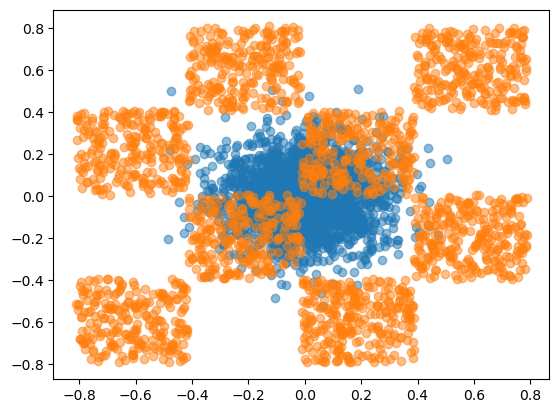

In [3]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

In [91]:
# define a model
from torchvision.ops import MLP
from tqdm import tqdm

device = "mps" if torch.mps.is_available() else "cpu"

model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 20000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []

for epoch in tqdm(range(num_epochs)):
    
    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)
    t = torch.rand(batch_size)
    x, y, t = x.to(device), y.to(device), t.to(device)
    
    # TODO: implement the training loop
    psi_t = (1 - t.unsqueeze(-1))*x + t.unsqueeze(-1)*y
    model_input = torch.cat([psi_t, t.unsqueeze(-1)], dim=-1)
    
    v_t = model(model_input)
    
    # Loss 
    v_true = y - x
    loss = criterion(v_t, v_true)  # Shape: (batch_size, 2)
    loss = loss.mean()
    losses.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|█████████████████████████████████████| 20000/20000 [07:03<00:00, 47.23it/s]


In [92]:
# TODO: run inference with the trained model.
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.


x0 = torch.randn(1500, 2) * base_distribution_std
x = x0.to(device)
t_values = torch.linspace(0, 1, 100 + 1, device=device)
dt = t_values[1] - t_values[0]  # Time step size

# Euler integration loop
for t in t_values:
    t_tensor = t.expand(x.size(0), 1) 
    model_input = torch.cat([x, t_tensor], dim=-1)
    v_t = model(model_input)
    x = x + dt * v_t

x = x.cpu().detach().numpy()

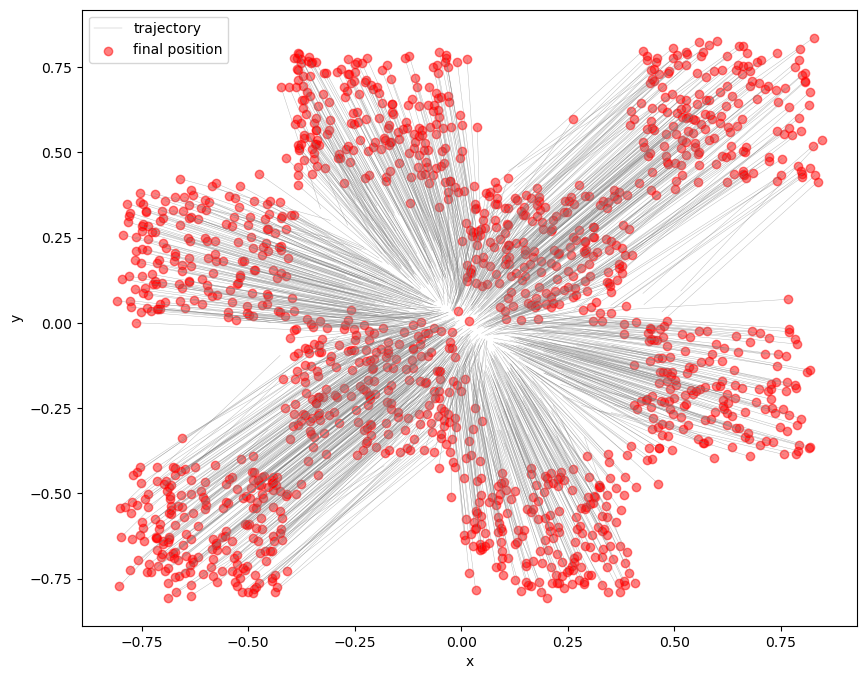

In [93]:
# Plot
xt_0 = x0[:, 0]
yt_0 = x0[:, 1]
xt_1 = x[:, 0]
yt_1 = x[:, 1]

plt.figure(figsize=(10, 8))

for i in range(len(xt_0)):
    x_values = [x0[i, 0], x[i, 0]]
    y_values = [x0[i, 1], x[i, 1]]
    if i == 0:
        plt.plot(x_values, y_values, linestyle='-', alpha=0.6, color='gray', linewidth=0.3, label='trajectory')
    else:
        plt.plot(x_values, y_values, linestyle='-', alpha=0.6, color='gray', linewidth=0.3)

plt.scatter(x[:, 0], x[:, 1], alpha=0.5, color='red', label='final position')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

b)

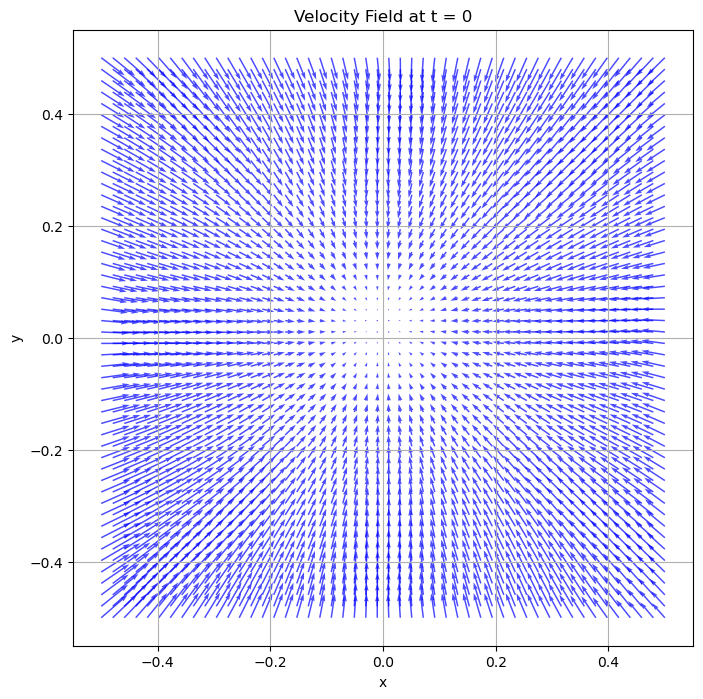

In [111]:
# Create a grid
grid_size = 50
x = np.linspace(-0.5, 0.5, grid_size)
y = np.linspace(-0.5, 0.5, grid_size)
X, Y = np.meshgrid(x, y)

grid_points = np.stack([X.flatten(), Y.flatten()], axis=-1)
grid_points_torch = torch.tensor(grid_points, dtype=torch.float32, device=device)

# Calculate velocity field
t = torch.zeros(1, device=device)
t_tensor = t.expand(grid_points_torch.size(0), 1) 
model_input = torch.cat([grid_points_torch, t_tensor], dim=-1)
v_t = model(model_input)

# Reshape
U = v_t[:, 0].detach().cpu().numpy().reshape(grid_size, grid_size)
V = v_t[:, 1].detach().cpu().numpy().reshape(grid_size, grid_size)

# Plot
plt.figure(figsize=(8, 8))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=10.0, color='blue', alpha=0.7)
plt.title("Velocity Field at t = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

The base distribution p and target distribution q are symmetrically distributed, with the center of both distributions  aligned near the origin. Thats why the velocity field points towards the center. This confirms the hypothesis.

## 3 Adversarial attacks and AI safety

a)

Tricking a probe to mislabel lies as truths is like an adversarial attack in machine learning. In adversarial attacks, small changes are made to the input to make the model give wrong outputs. For probes, the input is changed to affect the internal activations of a large language model (LLM), so the probe gets confused. Probes are tools that look at the LLM's internal state to decide if it is lying or telling the truth. By carefully changing the input, an attacker can fool the probe into thinking a lie is true. Both cases show how models and probes can be tricked if their patterns are manipulated.

In [4]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [5]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [16]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("train_labels.shape", train_labels.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels
learning_rate = 0.001
weight_decay = 0.1
epochs = 1000
device = 'mps'

model = LRProbe.from_data(acts=train_acts, labels=train_labels, lr=learning_rate, weight_decay=weight_decay, epochs=epochs, device=device)

predictions = model.pred(test_acts.to(device))
accuracy = (predictions == test_labels.to(device)).float().mean().item()
print(f"Accuracy: {accuracy:.4f}")

/Users/oliversange/mlph_w24/sheet10/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts = [t.load(os.path.join(directory, f'layer_{layer}_{i}.pt'),

train_acts.shape torch.Size([1196, 4096])
train_labels.shape torch.Size([1196])
Accuracy: 1.0000


In [42]:
# TODO: optimize a perturbation on a single sample which is a lie

# Select a sample
lie_indices = torch.where(train_labels == 0)[0]
x_sample = train_acts[lie_indices[10]]

# Ensure x_sample and target are on the correct device
x_sample = x_sample.to(device)
target = torch.tensor(1.0).to(device)  # Truth label, should be on the same device

# Perturbation
delta = torch.zeros_like(x_sample, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([delta], lr=0.01)

# Loss function
loss_fn = torch.nn.BCELoss()

# Training loop
for _ in range(100):  # Number of iterations
    optimizer.zero_grad()
    
    # Perturbed input
    x_perturbed = x_sample + delta
    
    # Prediction (ensure it returns a probability)
    y_pred = model.forward(x_perturbed).to(device)
    
    # Loss (maximize probability for the target class)
    loss = -loss_fn(y_pred, target)
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    # Stop early if the prediction is sufficiently close to 1
    if y_pred.item() > 0.99:
        break

# Final perturbation vector
print("Optimized perturbation vector:", delta.detach())

x_perturbed = x_sample + delta.detach()
perturbed_predictions = model.pred(x_perturbed)
print("Perturbed Predictions:", perturbed_predictions)

Optimized perturbation vector: tensor([ 0.1217, -0.1217, -0.1217,  ..., -0.1217,  0.1217, -0.1217],
       device='mps:0')
Perturbed Predictions: tensor(0., device='mps:0', grad_fn=<RoundBackward0>)


In [40]:
# TODO: check whether this perturbation works on other samples too

# Apply perturbation to all label-0 samples
train_acts_label_0 = train_acts[lie_indices]
train_acts_label_0_perturbed = train_acts_label_0.to(device) + delta.detach()

# Predictions before perturbation
original_predictions = model.pred(train_acts_label_0.to(device))

# Predictions after perturbation
perturbed_predictions = model.pred(train_acts_label_0_perturbed.to(device))

# Analyze results
print("Original Predictions:", original_predictions)
print("Perturbed Predictions:", perturbed_predictions)

Original Predictions: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

In [35]:
# TODO: add the constraint that the perturbation should be small



0.5552008115994623
